# Introduction to shallow supervised methods

In this section, we explain a few basic methods. Explaining the simple machine learning methods done in the first place makes it easier to understand the more complex ones. All the methods presented in this notebook are supervised methods. We start with linear classifiers, such as the Fisher classifier. To understand the linearity of the classifiers, we discuss the k nearest neighborhood method that is not linear by design and compare it to the Fisher's Linear Discriminant method. The last part of the linear section is dedicated to two regression methods: linear and logistic regression.

## Fisher classifier

The Fisher classifier use the linear discriminant analysis to classify the object into a class. The main idea of this classifier is to use the LDA to reduce the dimensionality and classify on the reduced feature space. In this notebook we use the Iris dataset to show how it works.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

# Loading the dataset with pandas
iris_data = load_iris()
iris_df = pd.DataFrame(iris_data.data,columns=iris_data.feature_names)
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


The LDA is implemented in scikit-learn and can be used for comparison as shown below.

In [2]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

x = iris_df[['sepal width (cm)','sepal length (cm)']].values.reshape(-1, 2)

clf = LinearDiscriminantAnalysis()
clf.fit(x,iris_data.target)
LinearDiscriminantAnalysis()

print(clf.predict([[5.0, 3.5]]))

[0]


## Fisher's classifier from scratch

We can implement the Fisher's classifier calculating the mean values.

In [3]:
x = iris_df['sepal width (cm)'].values
y = iris_df['sepal length (cm)'].values

dataset_size = np.size(x)

mean_x, mean_y = np.mean(x), np.mean(y)

SS_xy = np.sum(y * x) - dataset_size * mean_y * mean_x
SS_xx = np.sum(x * x) - dataset_size * mean_x * mean_x

a = SS_xy / SS_xx
b = mean_y - a * mean_x


y_pred = a * x + b

The data for the method developed from scratch needs to be normalized to eliminate scale factors.

In [7]:
from sklearn import preprocessing

iris_data, iris_labels = load_iris(return_X_y=True)
iris_data = np.array(preprocessing.normalize(iris_data))

The goal of the Fisher's classifier is to calculate the between-class variance with the class means ($m_{1}, m_{2}$), and the within-class variance ($S_{w}, S_{i}$). The means can be calculated as follows:
\begin{equation}
m_{i}=\frac{1}{n_{i}}\sum_{x\in i}x.
\end{equation}
The within-class variance can be calculated as follows:
\begin{equation}
S_w = \sum_{k=1}^{K}\sum_{n=1}^{C_k}N_k(x_n-m_k)(x_{n}-m_k)^{T}
\end{equation}
and
\begin{equation}
S_b = \sum_{k=1}^{K}(m_k - m)(m_k-m)^{T}.
\end{equation}
Finally, the weights can be calculated as follows:
\begin{equation}
w=S_{1}^{-1}(m_{+1}-m_{-1}).
\end{equation}
The discriminant function can be written as
\begin{equation}
\hat{g}(x)=w^{T}_{F}x=(m_{+1}-m_{-1})^{T}S_{W}^{-1}x,
\end{equation}
where:
\begin{equation}
w_{0}=\frac{1}{2}(w^{T}m_{+1}+w^{T}m_{-1}).
\end{equation}

In [8]:
x1 = iris_data[np.where(iris_labels == 1)][:,[0,1]]
x2 = iris_data[np.where(iris_labels == 2)][:,[0,1]]
y = iris_labels

mean_x1, mean_x2 = np.mean(x1,axis=0), np.mean(x2,axis=0)
mean = np.mean(np.append(x1,x2))

dataset_size = np.size(y)

Sb = np.sum((mean_x1-mean)*(mean_x2-mean))

Sw=np.dot((x1-mean_x1).T, (x1-mean_x1))+np.dot((x2-mean_x2).T, (x2-mean_x2))
w=np.dot(np.linalg.inv(Sw), (mean_x2-mean_x1))

cov = np.cov(np.concatenate((x1.T,x2.T)),ddof=0)
cov_inv = np.linalg.inv(cov)

We can now plot the same set, but with one dimension less.

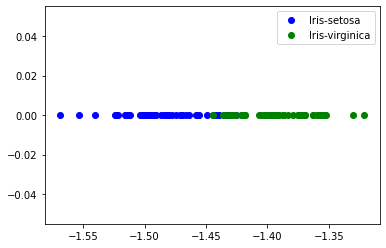

In [12]:
plt.plot(np.dot(x1, w), [0]*x1.shape[0], "bo", label="Iris-setosa")
plt.plot(np.dot(x2, w), [0]*x2.shape[0], "go", label="Iris-virginica")
plt.legend()
plt.show()

## Nearest neighbourhood classifier

In one sentence, kNN looks for other objects in the neighborhood and assigns the most popular label to new objects. The $k$ in the name is the number of objects that we look for labels in the neighborhood.

In [5]:
import numpy as np
import tensorflow_datasets as tfds
import pandas as pd
from math import sqrt
from sklearn.metrics import accuracy_score

# Construct a tf.data.Dataset
ds = tfds.load('titanic', split='train', shuffle_files=True)
titanic_df = tfds.as_dataframe(ds)

#titanic_df = pd.read_csv("titanic-train.csv")
titanic_df.drop("name", axis=1, inplace=True)
titanic_df.head()

columns = ['survived','age','fare']
features = columns[1:]
titanic_df = titanic_df[columns].replace([np.inf, -np.inf], np.nan).dropna()

titanic_df = titanic_df[titanic_df['fare'] > 30]

survivded_df = titanic_df[titanic_df['survived']==1].sample(50, random_state=12345)
not_survivded_df = titanic_df[titanic_df['survived']==0].sample(50, random_state=12345)

train_set = survivded_df.sample(40, random_state=12345)
train_set = pd.concat([train_set, not_survivded_df.sample(40, random_state=12345)])
plot_train_set = train_set
train_set_labels = train_set['survived']
train_set = train_set[features]


test_set = survivded_df.sample(10, random_state=12345)
test_set = pd.concat([test_set, not_survivded_df.sample(10, random_state=12345)])
plot_test_set = test_set
test_set_labels = test_set['survived']
test_set = test_set[features]

k = 5

def calculate_distance(x, v):
    """
    This method calculates the Euclidean distance between object x and v.

    :param x: first object
    :param v: second object
    :return: Euclidean distance
    """
    return sqrt((x[0] - v[0]) ** 2 + (x[1] - v[1]) ** 2)

def calculate_distance_matrix():
    """
    This method calculates the distance matrix between all objects.

    :return: A matrix of distances
    """    
    distance_matrix = np.zeros((len(data_set),len(data_set)))
    for i in range(len(data_set)):
        for j in range(len(data_set)):
            distance_matrix[i, j] = calculate_distance(data_set[i], data_set[j])
    return distance_matrix

def find_closest_objects(x, k):
    """
    Finds k closts objects to x.

    :return: A list of objects' ids.
    """        
    distances = []
    i = 0
    for item in train_set.values:
        distances.append([i, calculate_distance(x, item)])
        i = i + 1
    distances=np.array(distances)
    label_ids = distances[distances[:, 1].argsort()][:k,0]
    return [int(item) for item in label_ids]


def predict():
    """
    Assign a label of the most common label in the list of closest objects.

    :return: A list of predictions.
    """        
    predictions = []
    for item in test_set.values:
        label_ids = find_closest_objects(item, k)
        counts = np.bincount(train_set_labels.values[label_ids])
        label = np.argmax(counts)
        predictions.append(label)
    return predictions



predictions = predict()
acc = accuracy_score(predictions, test_set_labels)
print(acc)

0.6


In [6]:
plot_train_set.loc[plot_train_set["survived"] == 1, "survived"] = "green"
plot_train_set.loc[plot_train_set["survived"] == 0, "survived"] = "red"

In [7]:
plot_test_set['predicted'] = predictions

In [8]:
plot_test_set.loc[(plot_test_set["survived"] == 1) & (plot_test_set["predicted"] == 0), "survived"] = "black"
plot_test_set.loc[(plot_test_set["survived"] == 1) & (plot_test_set["predicted"] == 1), "survived"] = "blue"
plot_test_set.loc[(plot_test_set["survived"] == 0) & (plot_test_set["predicted"] == 0), "survived"] = "orange"
plot_test_set.loc[(plot_test_set["survived"] == 0) & (plot_test_set["predicted"] == 1), "survived"] = "purple"
plot_test_set.drop(['predicted'],axis=1)

,survived,age,fare
152,blue,24.0,69.300003
872,blue,23.0,82.266701
479,blue,44.0,57.979198
1102,black,34.0,32.500000
227,blue,48.0,76.729202
478,black,52.0,30.500000
1031,black,4.0,39.000000
1149,black,48.0,65.000000
881,black,27.0,76.729202
821,black,53.0,51.479198


In [10]:
plot_set = pd.concat([plot_test_set, plot_train_set])

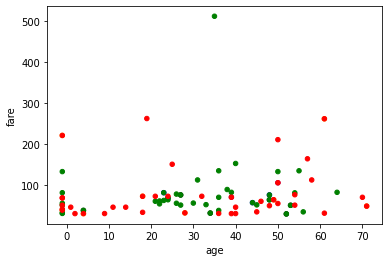

In [11]:
res = plot_set.plot.scatter(x='age',y='fare',c='survived').get_figure()

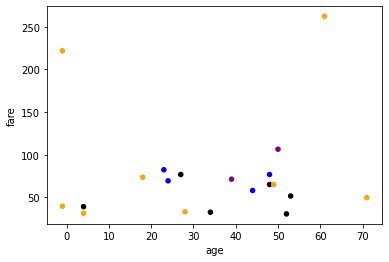

In [13]:
res = plot_test_set.plot.scatter(x='age',y='fare',c='survived').get_figure()

# Linear regression

Linear regression is the simplest linear method used for modelling the relationship between the independent variables and the dependent ones. It tries to estimate it by finding a line which is as close as possible to all the data points. 

\begin{equation}
y=ax+b
\end{equation}

In [ ]:
boston_housing_df.plot(x="CRIM", y="MEDV", kind="scatter")

from sklearn.linear_model import LinearRegression

# Create an instance of LinearRegression and find the coeffs
linear_regression = LinearRegression()
linear_regression.fit(X=boston_housing_df[["CRIM"]], 
                      y=boston_housing_df["MEDV"])
linear_regression.coef_, linear_regression.intercept_ 

We can try to draw the linear regression $y$ using matplotlib. In the code below we take the MEDV features as $y$ and CRIM as $x$.

In [ ]:
# Create a polynomial to be drawn on the plot
coefficients = np.append(linear_regression.coef_, 
                         linear_regression.intercept_)
polynomial = np.poly1d(coefficients)

# Calculate the values for a selected range
x_values = np.linspace(0, boston_housing_df["CRIM"].max())
y_values = polynomial(x_values)

# Display a scatter plot: crim vs medv and regressed line
boston_housing_df.plot(x="CRIM", y="MEDV", kind="scatter")
plt.plot(x_values, y_values, color="red", linestyle="dashed")

from sklearn.metrics import mean_squared_error

y_pred = linear_regression.predict(boston_housing_df[["CRIM"]]) 
y_true = boston_housing_df["MEDV"]
mean_squared_error(y_true, y_pred)

In [ ]:
# Calculate the Pearson correlation coefficients
boston_housing_df.corr()["MEDV"]

The absolute value of correlation coefficients is highest for *rm* (0.689598) and *lstat* (-0.738600). That means, these values are possibly the best predictors for the target variable and we can consider them in a 3D regression.

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Display 3D scatter: rm, lstat vs medv
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(boston_housing_df["RM"], boston_housing_df["LSTAT"], 
           boston_housing_df["MEDV"], c="blue")
plt.show()

Let's find the coefficiencies and build a linear regression instance.

In [ ]:
linear_regression = LinearRegression()
linear_regression.fit(X=boston_housing_df[["RM", "LSTAT"]], 
                      y=boston_housing_df["MEDV"])
linear_regression.coef_, linear_regression.intercept_ 

For a three-dimensional case we need to calculate three values. We get three coeffiencies that are used to get the $z$ values.

In [ ]:
# Calculate coefficients of 2d polynomial
coefficients = np.append(linear_regression.coef_, 
                         linear_regression.intercept_)

# Calculate the values for a selected range
x = np.linspace(0, boston_housing_df["RM"].max())
y = np.linspace(0, boston_housing_df["LSTAT"].max())
x_values, y_values = np.meshgrid(x, y)
z_values = coefficients[0] * x_values + coefficients[1] * y_values + coefficients[2]

# Display 3D scatter: rm, lstat vs medv and regressed line
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(boston_housing_df["RM"], boston_housing_df["LSTAT"], 
           boston_housing_df["MEDV"], c="blue")
ax.plot_surface(x_values, y_values, z_values, linewidth=0.2, 
                color="red", alpha=0.5)
angle=30
ax.view_init(30, angle)
plt.show()

The prediction of linear regression can be done with the ``predict`` method. The cost function of a linear regression is calculated with mean squared error function.

In [ ]:
y_pred = linear_regression.predict(boston_housing_df[["RM", "LSTAT"]]) 
y_true = boston_housing_df["MEDV"]
mean_squared_error(y_true, y_pred)

To understand the method in more details we use a simple example of humans heights and weights values.

In [16]:
heights = np.array([188, 181, 197, 168, 167, 187, 178, 194, 140, 176, 168, 192, 173, 142, 176]).reshape(-1, 1)
weights = np.array([141, 106, 149, 59, 79, 136, 65, 136, 52, 87, 115, 140, 82, 69, 121]).reshape(-1, 1)

For comparison, we use the linear regression available in sklearn library. 

In [19]:
from sklearn import linear_model
import numpy as np
import matplotlib.pyplot as plt

regr = linear_model.LinearRegression()
regr.fit(heights, weights)

LinearRegression()

As in the previous example, we can plot the slope.

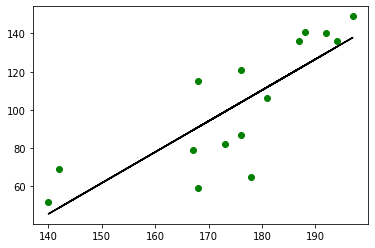

In [20]:
plt.scatter(heights, weights,color='g')
plt.plot(heights, regr.predict(heights),color='k')

plt.show()

The coeffieciencies are calculated as:

In [21]:
print(regr.coef_)
print(regr.intercept_)

[[1.61814247]]
[-180.92401772]


If we calcualte the $y$ value for $x=150$:

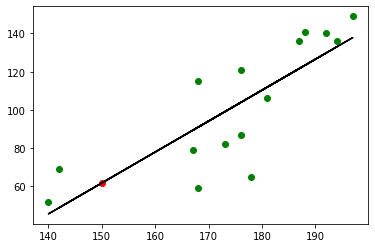

In [22]:
plt.scatter(heights, weights,color='g')
plt.plot(heights, regr.predict(heights),color='k')

x= 150
y = 61.797
plt.scatter(x, y,color='r')

plt.show()

## Linear regression from scratch

And now we can use the data set to implement the linear regression from scratch.

In [23]:
x = heights.reshape(15,1)
y = weights.reshape(15,1)

We should add the bias column before doing the calculation. 

In [24]:
x = np.append(x, np.ones((15,1)), axis = 1)

The equation for calculating the weights is 
\begin{equation}
(X^{T}X)^{-1}X^{T}y
\end{equation}

In [25]:
w = np.dot(np.linalg.inv(np.dot(np.transpose(x),x)),np.dot(np.transpose(x),y))

The weitghs we can as the output are exaclty the same as we get using sklearn implementation of the linear regression method.

In [26]:
w

array([[   1.61814247],
       [-180.92401772]])

To make the prediction a bit easier, we can implement a short function where the arguments are: 
- inputs - feature $x$ of objects,
- w - weights,
- b - bias.
The calculation is easy and use the linear regression equation $y=wx+b$.

In [27]:
def reg_predict(inputs, w, b):
    results = []
    for inp in inputs:
        results.append(inp*w+b)
    return results

Finally, we can plot the predicted values using the function above.

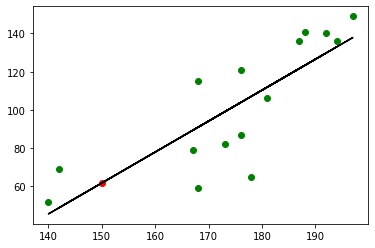

In [28]:
plt.scatter(heights.flatten(), weights.flatten(),color='g')
plt.plot(heights.flatten(), reg_predict(heights.flatten(), w[0], w[1]) ,color='k')

x1 = 150
y = reg_predict([x1], w[0], w[1])[0]
plt.scatter(x1, y,color='r')

plt.show()

In [29]:
reg_predict(x.flatten(), w[1], w[0])

[array([-34012.0971882]),
 array([-179.30587525]),
 array([-32745.62906419]),
 array([-179.30587525]),
 array([-35640.41334765]),
 array([-179.30587525]),
 array([-30393.61683388]),
 array([-179.30587525]),
 array([-30212.69281616]),
 array([-179.30587525]),
 array([-33831.17317049]),
 array([-179.30587525]),
 array([-32202.85701104]),
 array([-179.30587525]),
 array([-35097.6412945]),
 array([-179.30587525]),
 array([-25327.74433782]),
 array([-179.30587525]),
 array([-31841.00897561]),
 array([-179.30587525]),
 array([-30393.61683388]),
 array([-179.30587525]),
 array([-34735.79325907]),
 array([-179.30587525]),
 array([-31298.23692246]),
 array([-179.30587525]),
 array([-25689.59237325]),
 array([-179.30587525]),
 array([-31841.00897561]),
 array([-179.30587525])]

# Ridge regression

Ridge regression use a regularizer and the equation is a bit more complex compare to the regular linear regression:
\begin{equation}
 \sum_{i=1}^{M}(y_{i}-\sum_{j=0}^{p}w_{j}\dot x_{ij})^{2} + \lambda\sum_{j=0}^{p}w^{2}_{j}.
\end{equation}
We have an additional parameter $\lambda$ that is known in sklearn as $\alpha$. It's the regularizer that together with $w^{2}_{j}$ is known as the L2 regularizator.

In [30]:
from sklearn.linear_model import Ridge

alpha = 0.1

heights1 = np.asmatrix(np.c_[np.ones((15,1)), heights])

ridge_regression = Ridge(alpha=alpha, fit_intercept=False)
ridge_regression.fit(X=heights1, 
                      y=weights)
ridge_regression.coef_, ridge_regression.intercept_ 

/Users/kprzystalski/miniforge3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


(array([[-101.72397081,    1.16978757]]), 0.0)

Similar to the regular linear regression, the slop can be drawn as below.

/Users/kprzystalski/miniforge3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


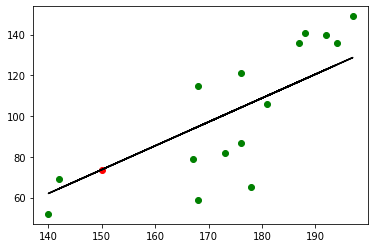

In [31]:
plt.scatter(heights, weights,color='g')
plt.plot(heights, ridge_regression.predict(heights1),color='k')

x = 150
y = reg_predict([150], ridge_regression.coef_[0][1], ridge_regression.coef_[0][0])[0]
plt.scatter(x, y,color='r')

y = ridge_regression.coef_[0][1] * 150 + ridge_regression.coef_[0][0]

plt.show()

For $x_{1}=150$ the result is a bit different compared to the regression without the regularization.

In [34]:
w=w.ravel()

The plot looks as below. We see the the slope start with higer $y$ values compared to the regular linear regression.

# Lasso regression

Lasso regression uses the L1 regularization. The equation is very similar to the Ridge one, but instead of $w^{2}$ we use the magnitude of $w$. 

\begin{equation}
 \sum_{i=1}^{M}(y_{i}-\sum_{j=0}^{p}w_{j}\dot x_{ij})^{2} + \lambda\sum_{j=0}^{p}|w_{j}|.
\end{equation}

In [36]:
from sklearn.linear_model import Lasso

alpha = 0.1
heights1 = np.asmatrix(np.c_[np.ones((15,1)), heights])

lasso_regression = Lasso(alpha=alpha)
lasso_regression.fit(X=heights, 
                      y=weights)
lasso_regression.coef_, lasso_regression.intercept_ 

(array([1.61776499]), array([-180.8579086]))

We can plot the slope as in the previous example.

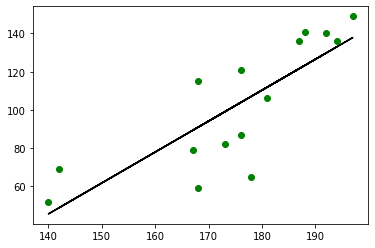

In [37]:
plt.scatter(heights, weights,color='g')
plt.plot(heights, lasso_regression.predict(heights),color='k')

plt.show()

### Stochastic Gradient Decent (SGD) 

The way of calculating the linear regression as shown in the previous section is simple, but for many cases not efficient. A different way and one of the most popular methods to find the proper weights are the mean squared error and the stochastic gradient descent, where the first is formulated as:
\begin{equation}
  MSE = \frac{1}{n}\sum_{i=1}^{n}(y-\hat{y})^{2}.
\end{equation}
MSE or modification of it can be used to implement a stochastic gradient descent (SGD). A cost function in linear regression is defined as following:
\begin{equation}
\sum_{i=1}^{M}(y_{i}-\sum_{j=0}^{p}w_{j}\dot x_{ij})^{2}.
\end{equation}

The SGD implementation is given below.

In [51]:
def sgd(coeffs, x, y, epochs, rate = 0.1, l1 = 0.1):
    norm = np.linalg.norm(x, axis = 0)
    w = coeffs[0]
    b = coeffs[1
    m = y.shape[0]
    n = x.shape[1]
    for i in range(epochs):
        x_in = x[:,1].reshape(-1, 1)
        y_pred = x_in * w + b
        if w > 0:
            dW = (- (2 * x_in.T.dot(y - y_pred)) + l1 ) / norm[1] ** 2
        else:
            dW = (- (2 * x_in.T.dot(y - y_pred)) - l1 ) / norm[1] ** 2
        db = - 2 * np.sum(y - y_pred) // norm[0] ** 2
        w = w - rate * dW
        b = b - rate * db
    coeffs[0] = b
    coeffs[1] = w
    return coeffs

We use the same BMI data set, but the execution it slightly different. 

In [56]:
x = np.array([188, 181, 197, 168, 167, 187, 178, 194, 140, 176, 168, 192, 173, 142, 176]).reshape(-1, 1).reshape(15,1)
y = np.array([141, 106, 149, 59, 79, 136, 65, 136, 52, 87, 115, 140, 82, 69, 121]).reshape(-1, 1).reshape(15,1)

x = np.asmatrix(np.c_[np.ones((len(x),1)),x])

I = np.identity(2)
alpha = 0.1 

init_c = np.zeros((2,1))
results = []

w2 = sgd(init_c, x, y, 10, 0.1, alpha)
w2 = w2.ravel()
results.append(w2)

w1 = np.linalg.inv(x.T * x + alpha * I) * x.T * y
w1 = w1.ravel()
w1 = np.squeeze(np.asarray(w1))
results.append(w1)

The plot is similar to the previous example, becauce of small data set. The weigths and bias are slightly different comapred to previous.

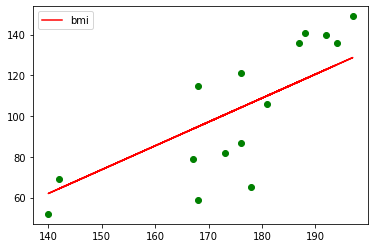

In [57]:
plt.scatter(heights, weights,color='g')
plt.plot(heights.flatten(), reg_predict(heights.flatten(), w.item(1), w.item(0)) ,label='bmi',color='red')
plt.legend(loc='best')
plt.show()

## Naive Bayes

The Iris data set consits of three classes. To simplify the usage of Naive Bayes method we use only two. The data preparation is given below.

In [ ]:
from sklearn.model_selection import train_test_split

iris = load_iris()
data_set = iris.data
labels = iris.target
data_set = data_set[:,:2]

data_set = data_set[labels!=2]
labels = labels[labels!=2]

train_data_set, test_data_set, train_labels, test_labels = train_test_split(
    data_set, labels, test_size=0.2, random_state=15)

train_labels[train_labels<1] = -1
test_labels[test_labels<1] = -1

train_size = len(train_labels)
test_size = len(test_labels)
label_count = 2
feature_count = 2

mean_label0 = np.mean(train_data_set[[np.where(train_labels==-1)]][0],axis=1)
mean_label1 = np.mean(train_data_set[[np.where(train_labels==1)]][0],axis=1)

std0 = np.std(train_data_set[[np.where(train_labels==-1)]][0],axis=1)
std1 = np.std(train_data_set[[np.where(train_labels==1)]][0],axis=1)

The functions are next limited to two classes in the `naive_bayes_classifier` function. We changed the classes to 1 and -1 to simplify the classification. The other function are changes slightly to get the means from a list

In [154]:
from math import exp
from math import pi

def naive_bayes_classifier(x):
    probabilities = []

    label = -1
    class_probability = train_size / (train_size * label_count)

    label_zero_probability = calculate_probability(x, class_probability, mean_label0, std0)
    probabilities.append(label_zero_probability)

    label_one_probability = calculate_probability(x, class_probability, mean_label1, std1)
    if label_one_probability > label_zero_probability:
        label = 1
    probabilities.append(label_one_probability)

    return label, probabilities


def gaussian_pdf(x, mean, stdev):
    exponent = exp(-((x-mean)**2 / (2 * stdev**2)))
    return (1 / (sqrt(2 * pi) * stdev)) * exponent


def calculate_probability(x, class_probability, mean, stdev):
    probability = class_probability
    i = 0
    for feature in range(feature_count):
        probability *= gaussian_pdf(x[i], mean[0][feature], stdev[0][feature])
        i = i + 1
    return probability

It is interesting that for many randomly chosen test and train sets, this method achieves an accuracy of 100%.

In [167]:
results_prob = []
prediction = []
for x in  test_data_set:
    pred, probabilities = naive_bayes_classifier(x)
    results_prob.append(probabilities)
    prediction.append(pred)

print(accuracy_score(prediction, test_labels))

1.0
